In [1]:
!pip install pandas numpy scikit-learn imbalanced-learn tabulate matplotlib seaborn xgboost --quiet


In [2]:
import pandas as pd
import numpy as np

# Set random seed for reproducibility
np.random.seed(42)

# Parameters
n_samples = 100_000  # Large enough for advanced modeling
fraud_rate = 0.002   # ~0.2% fraud, typical for AU card fraud

# Feature pools
merchant_categories = [
    'Supermarket', 'Online Retail', 'Fuel', 'Electronics', 'Travel', 'Hospitality', 'Gambling', 'Utilities'
]
states = ['NSW', 'VIC', 'QLD', 'WA', 'SA', 'TAS', 'ACT', 'NT']

# Generate data
data = {
    'transaction_id': np.arange(n_samples),
    'timestamp': pd.date_range('2024-01-01', periods=n_samples, freq='min'),
    'amount': np.round(np.random.exponential(scale=80, size=n_samples), 2),
    'merchant_category': np.random.choice(merchant_categories, size=n_samples),
    'state': np.random.choice(states, size=n_samples, p=[0.32,0.25,0.20,0.10,0.07,0.03,0.02,0.01]),
    'card_present': np.random.choice([0, 1], size=n_samples, p=[0.3, 0.7]),
    'international': np.random.choice([0, 1], size=n_samples, p=[0.95, 0.05]),
}

# Assign fraud labels (simulate higher risk for some patterns)
df = pd.DataFrame(data)
df['is_fraud'] = np.random.choice([0, 1], size=n_samples, p=[1-fraud_rate, fraud_rate])

# Add some pattern: higher fraud in online, international, high amount
fraud_indices = df[
    (df['merchant_category'].isin(['Online Retail', 'Gambling', 'Electronics'])) &
    ((df['amount'] > 500) | (df['international'] == 1))
].sample(frac=0.1, random_state=42).index
df.loc[fraud_indices, 'is_fraud'] = 1

print(df.head())
print(df['is_fraud'].value_counts())


   transaction_id           timestamp  amount merchant_category state  \
0               0 2024-01-01 00:00:00   37.54     Online Retail   NSW   
1               1 2024-01-01 00:01:00  240.81         Utilities   QLD   
2               2 2024-01-01 00:02:00  105.34       Hospitality    WA   
3               3 2024-01-01 00:03:00   73.04          Gambling   QLD   
4               4 2024-01-01 00:04:00   13.57       Supermarket    WA   

   card_present  international  is_fraud  
0             1              0         0  
1             0              0         0  
2             0              0         0  
3             1              0         0  
4             1              0         0  
is_fraud
0    99611
1      389
Name: count, dtype: int64


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Shape and missing values
print("Shape:", df.shape)
print("\nMissing values:\n", df.isnull().sum())

# Class distribution
fraud_counts = df['is_fraud'].value_counts()
print("\nClass distribution:\n", fraud_counts)
print("\nFraud rate: {:.4f}%".format(100 * fraud_counts[1] / len(df)))


Shape: (100000, 8)

Missing values:
 transaction_id       0
timestamp            0
amount               0
merchant_category    0
state                0
card_present         0
international        0
is_fraud             0
dtype: int64

Class distribution:
 is_fraud
0    99611
1      389
Name: count, dtype: int64

Fraud rate: 0.3890%


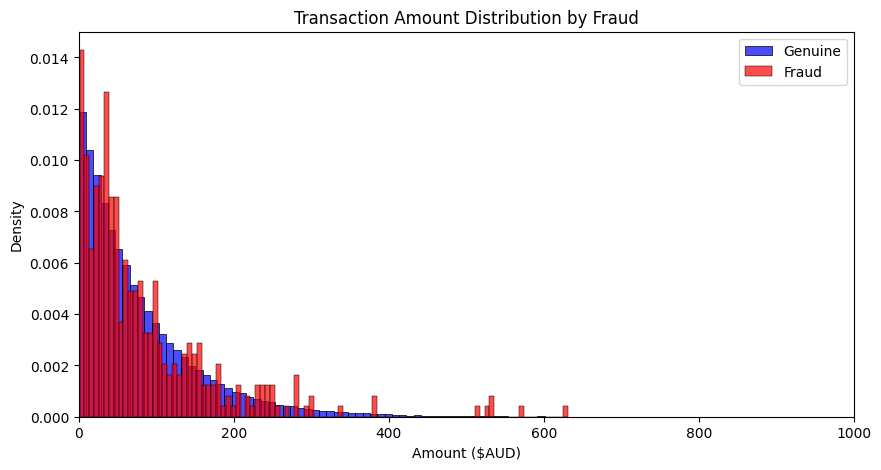

In [4]:
plt.figure(figsize=(10,5))
sns.histplot(df[df['is_fraud']==0]['amount'], bins=100, color='blue', label='Genuine', stat='density', alpha=0.7)
sns.histplot(df[df['is_fraud']==1]['amount'], bins=100, color='red', label='Fraud', stat='density', alpha=0.7)
plt.legend()
plt.title('Transaction Amount Distribution by Fraud')
plt.xlabel('Amount ($AUD)')
plt.ylabel('Density')
plt.xlim(0, 1000)
plt.show()


<ipython-input-5-225214983309>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fraud_by_cat.index, y=fraud_by_cat.values, palette='viridis')


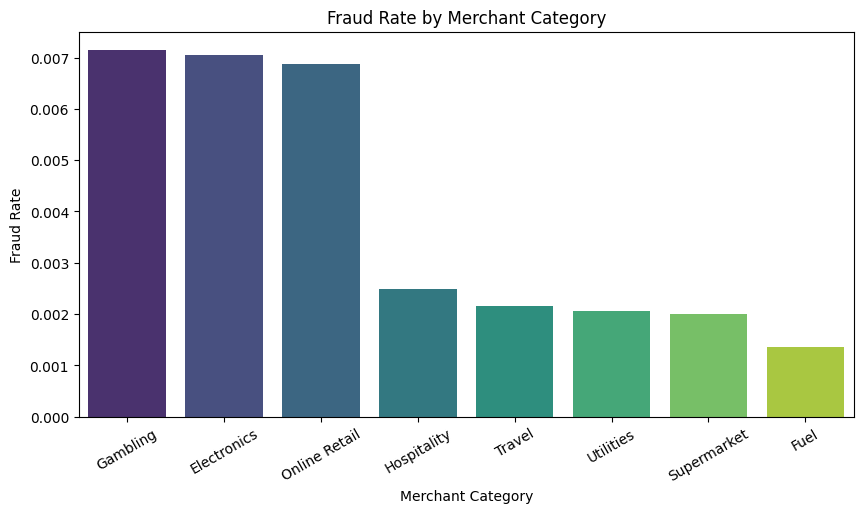

In [5]:
plt.figure(figsize=(10,5))
fraud_by_cat = df.groupby('merchant_category')['is_fraud'].mean().sort_values(ascending=False)
sns.barplot(x=fraud_by_cat.index, y=fraud_by_cat.values, palette='viridis')
plt.title('Fraud Rate by Merchant Category')
plt.ylabel('Fraud Rate')
plt.xlabel('Merchant Category')
plt.xticks(rotation=30)
plt.show()


<ipython-input-6-e69b5a8f7b3e>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fraud_by_state.index, y=fraud_by_state.values, palette='mako')


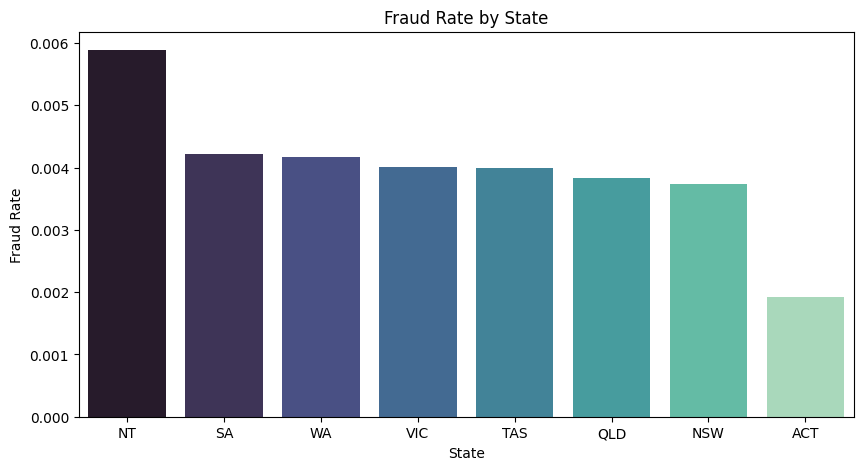

In [6]:
plt.figure(figsize=(10,5))
fraud_by_state = df.groupby('state')['is_fraud'].mean().sort_values(ascending=False)
sns.barplot(x=fraud_by_state.index, y=fraud_by_state.values, palette='mako')
plt.title('Fraud Rate by State')
plt.ylabel('Fraud Rate')
plt.xlabel('State')
plt.show()


<ipython-input-7-560b8b799192>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['No','Yes'], y=df.groupby('card_present')['is_fraud'].mean().values, palette='Set2')
<ipython-input-7-560b8b799192>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Domestic','International'], y=df.groupby('international')['is_fraud'].mean().values, palette='Set1')


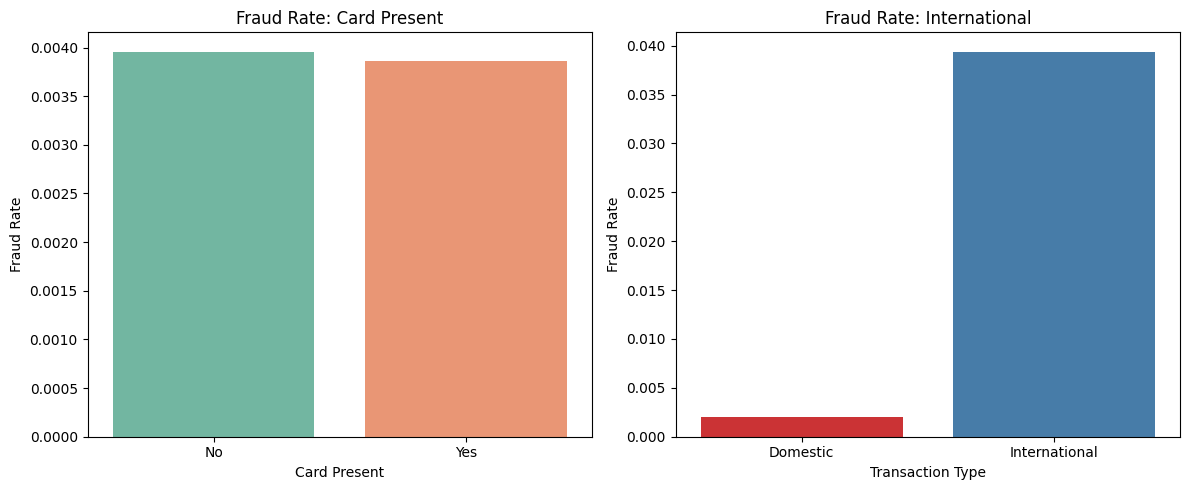

In [7]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.barplot(x=['No','Yes'], y=df.groupby('card_present')['is_fraud'].mean().values, palette='Set2')
plt.title('Fraud Rate: Card Present')
plt.ylabel('Fraud Rate')
plt.xlabel('Card Present')

plt.subplot(1,2,2)
sns.barplot(x=['Domestic','International'], y=df.groupby('international')['is_fraud'].mean().values, palette='Set1')
plt.title('Fraud Rate: International')
plt.ylabel('Fraud Rate')
plt.xlabel('Transaction Type')
plt.tight_layout()
plt.show()


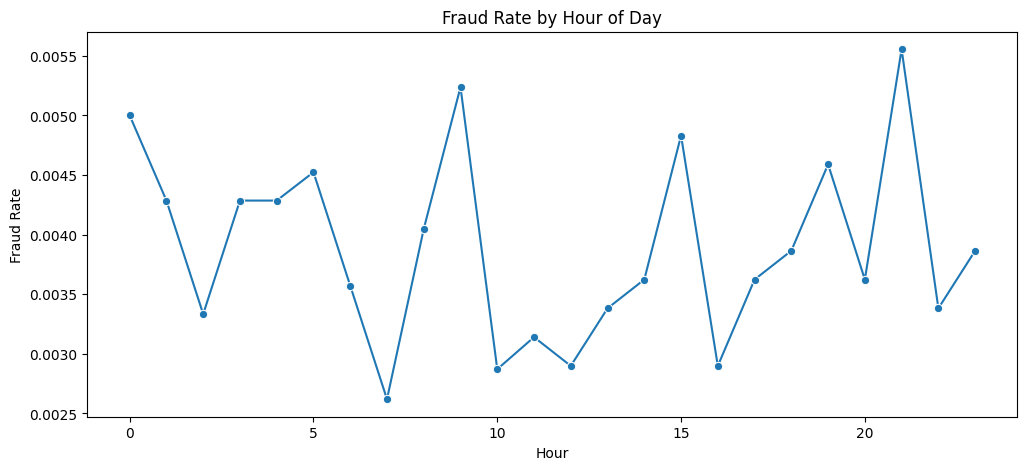

In [8]:
df['hour'] = df['timestamp'].dt.hour

plt.figure(figsize=(12,5))
sns.lineplot(x='hour', y='is_fraud', data=df.groupby('hour')['is_fraud'].mean().reset_index(), marker='o')
plt.title('Fraud Rate by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Fraud Rate')
plt.show()


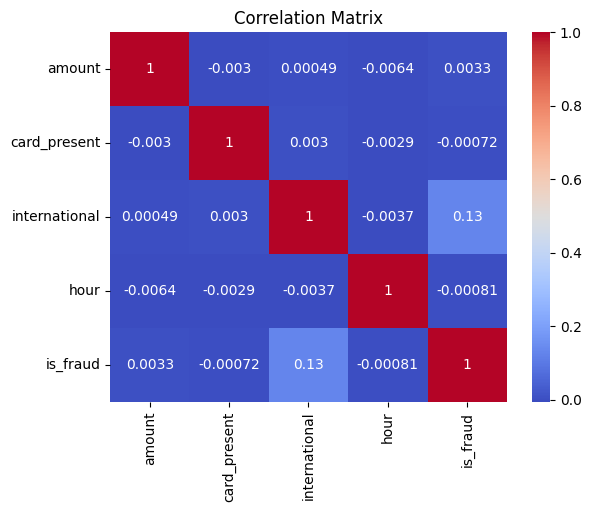

In [9]:
corr = df[['amount', 'card_present', 'international', 'hour', 'is_fraud']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


In [10]:
from sklearn.model_selection import train_test_split

# One-hot encode merchant_category and state
df_encoded = pd.get_dummies(df, columns=['merchant_category', 'state'], drop_first=True)

# Drop columns not needed for modeling
df_encoded = df_encoded.drop(['transaction_id', 'timestamp'], axis=1)


In [11]:
# High amount flag
df_encoded['high_amount'] = (df['amount'] > 500).astype(int)

# Risky merchant flag
df_encoded['risky_merchant'] = df['merchant_category'].isin(['Online Retail', 'Gambling', 'Electronics']).astype(int)

# Night transaction flag
df_encoded['night_txn'] = df['hour'].between(22, 23) | df['hour'].between(0, 6)
df_encoded['night_txn'] = df_encoded['night_txn'].astype(int)


In [12]:
X = df_encoded.drop('is_fraud', axis=1)
y = df_encoded['is_fraud']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print("Train set size:", X_train.shape)
print("Test set size:", X_test.shape)


Train set size: (80000, 21)
Test set size: (20000, 21)


In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train[['amount', 'hour']] = scaler.fit_transform(X_train[['amount', 'hour']])
X_test[['amount', 'hour']] = scaler.transform(X_test[['amount', 'hour']])


In [14]:
from imblearn.over_sampling import SMOTE

print("Before SMOTE:", y_train.value_counts())
sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)
print("After SMOTE:", y_train_bal.value_counts())


Before SMOTE: is_fraud
0    79689
1      311
Name: count, dtype: int64
After SMOTE: is_fraud
0    79689
1    79689
Name: count, dtype: int64


In [15]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score

# Train XGBoost
model = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=1, # SMOTE already balanced
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)
model.fit(X_train_bal, y_train_bal)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:36:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [16]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

print("Classification Report:\n", classification_report(y_test, y_pred, digits=4))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_proba)
pr_auc = average_precision_score(y_test, y_proba)
print(f"ROC AUC: {roc_auc:.4f}")
print(f"PR AUC: {pr_auc:.4f}")


Classification Report:
               precision    recall  f1-score   support

           0     0.9978    0.9824    0.9901     19922
           1     0.0909    0.4487    0.1512        78

    accuracy                         0.9804     20000
   macro avg     0.5444    0.7156    0.5706     20000
weighted avg     0.9943    0.9804    0.9868     20000

Confusion Matrix:
 [[19572   350]
 [   43    35]]
ROC AUC: 0.6998
PR AUC: 0.0586


In [17]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

print("Classification Report:\n", classification_report(y_test, y_pred, digits=4))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_proba)
pr_auc = average_precision_score(y_test, y_proba)
print(f"ROC AUC: {roc_auc:.4f}")
print(f"PR AUC: {pr_auc:.4f}")


Classification Report:
               precision    recall  f1-score   support

           0     0.9978    0.9824    0.9901     19922
           1     0.0909    0.4487    0.1512        78

    accuracy                         0.9804     20000
   macro avg     0.5444    0.7156    0.5706     20000
weighted avg     0.9943    0.9804    0.9868     20000

Confusion Matrix:
 [[19572   350]
 [   43    35]]
ROC AUC: 0.6998
PR AUC: 0.0586


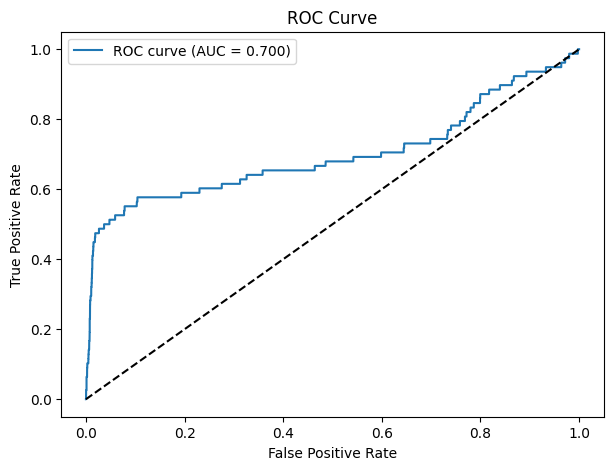

In [18]:
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


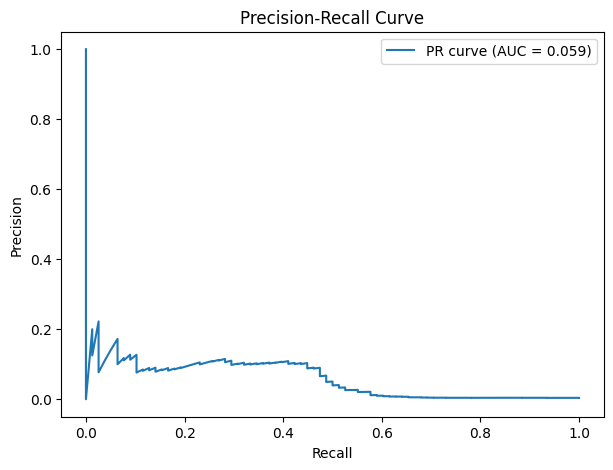

In [19]:
precision, recall, _ = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(7,5))
plt.plot(recall, precision, label=f'PR curve (AUC = {pr_auc:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()


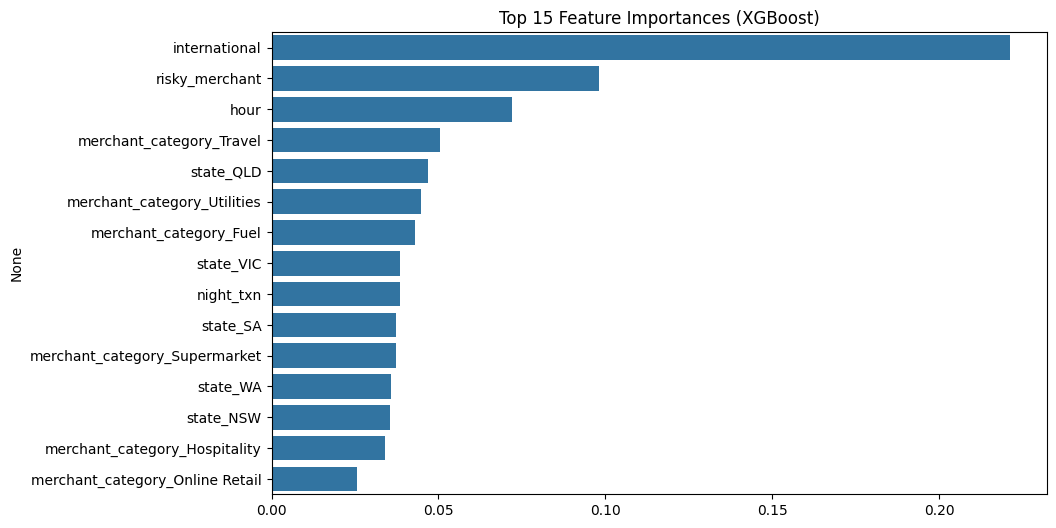

In [20]:
importances = model.feature_importances_
feat_names = X_train.columns
feat_imp = pd.Series(importances, index=feat_names).sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=feat_imp.values[:15], y=feat_imp.index[:15])
plt.title('Top 15 Feature Importances (XGBoost)')
plt.show()


In [21]:
!pip install pytorch-tabnet --quiet
import torch
from pytorch_tabnet.tab_model import TabNetClassifier


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 84.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 79.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.3 MB/s eta 0:00:00


In [22]:
# Convert all columns to float (including bool columns)
X_train_bal = X_train_bal.astype(float)
X_test = X_test.astype(float)


In [23]:
# Convert to numpy arrays
X_train_tabnet = X_train_bal.values
y_train_tabnet = y_train_bal.values
X_test_tabnet = X_test.values
y_test_tabnet = y_test.values


In [24]:
print(X_train_bal.dtypes)


amount                             float64
card_present                       float64
international                      float64
hour                               float64
merchant_category_Fuel             float64
merchant_category_Gambling         float64
merchant_category_Hospitality      float64
merchant_category_Online Retail    float64
merchant_category_Supermarket      float64
merchant_category_Travel           float64
merchant_category_Utilities        float64
state_NSW                          float64
state_NT                           float64
state_QLD                          float64
state_SA                           float64
state_TAS                          float64
state_VIC                          float64
state_WA                           float64
high_amount                        float64
risky_merchant                     float64
night_txn                          float64
dtype: object


In [25]:
tabnet_params = {
    'n_d': 16,          # Width of the decision prediction layer
    'n_a': 16,          # Width of the attention embedding for each mask
    'n_steps': 5,       # Number of steps in the architecture
    'gamma': 1.5,       # Relaxation parameter in the sparsemax
    'lambda_sparse': 1e-4,
    'optimizer_fn': torch.optim.Adam,
    'optimizer_params': dict(lr=2e-2),
    'mask_type': 'sparsemax',
    'verbose': 10
}

tabnet = TabNetClassifier(**tabnet_params)

tabnet.fit(
    X_train_tabnet, y_train_tabnet,
    eval_set=[(X_test_tabnet, y_test_tabnet)],
    eval_name=['test'],
    eval_metric=['auc'],
    max_epochs=50,
    patience=10,
    batch_size=1024,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.55666 | test_auc: 0.69037 |  0:00:23s
epoch 10 | loss: 0.29024 | test_auc: 0.70377 |  0:03:08s

Early stopping occurred at epoch 13 with best_epoch = 3 and best_test_auc = 0.73929


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [26]:
!pip install shap --quiet
import shap


<ipython-input-27-7439ec3047d1>:6: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_xgb, X_test, plot_type="bar", show=True)


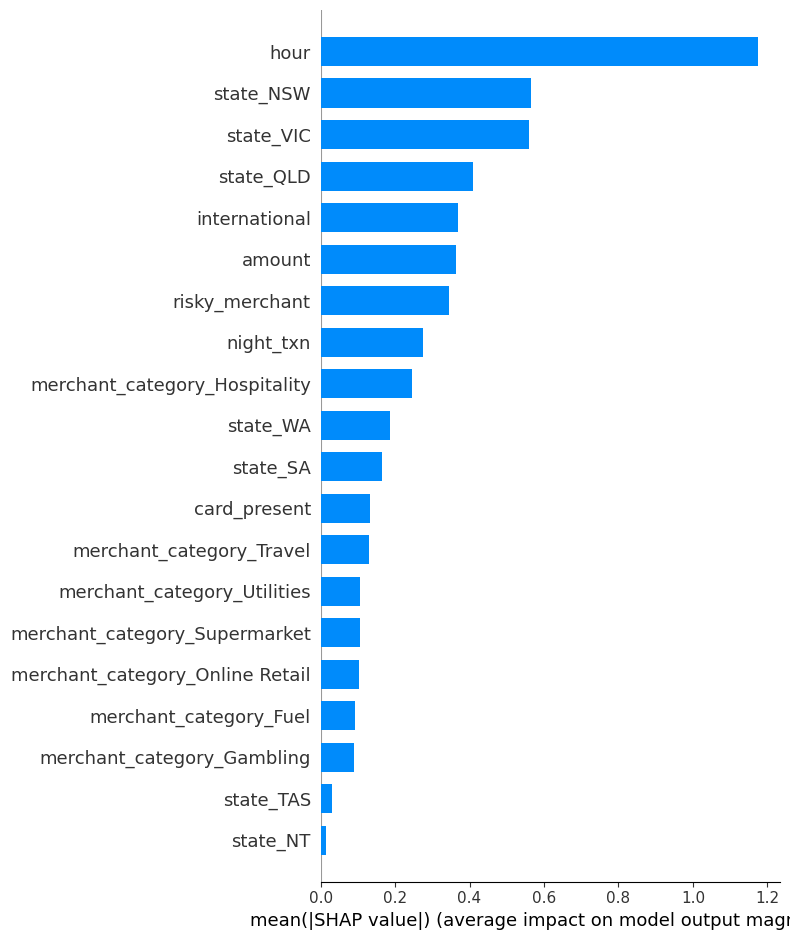

In [27]:
# Create a TreeExplainer for XGBoost
explainer_xgb = shap.TreeExplainer(model)
shap_values_xgb = explainer_xgb.shap_values(X_test)

# Summary plot (global feature importance)
shap.summary_plot(shap_values_xgb, X_test, plot_type="bar", show=True)


<ipython-input-28-c02e24712787>:2: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_xgb, X_test, show=True)


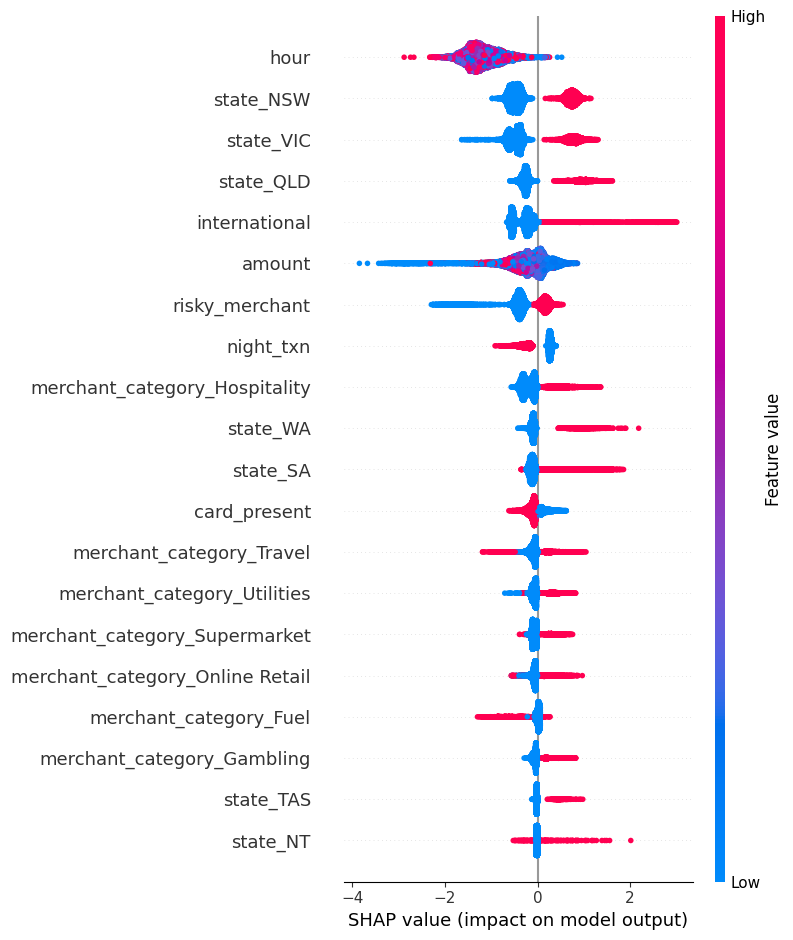

In [28]:
# Beeswarm plot for more detailed view
shap.summary_plot(shap_values_xgb, X_test, show=True)


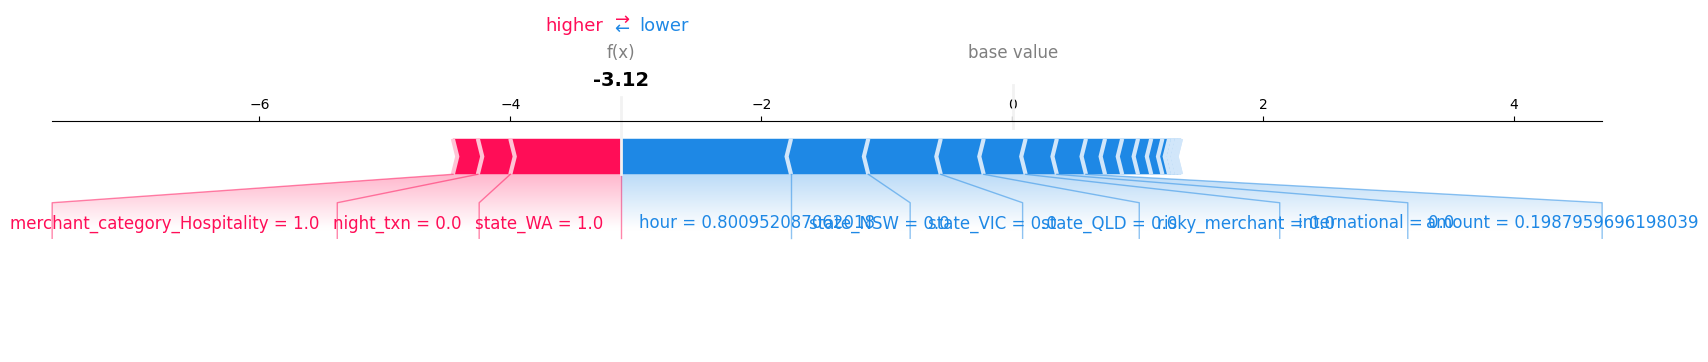

In [32]:
# Find the first fraud case in the test set by position
fraud_pos = (y_test.reset_index(drop=True) == 1).idxmax()

# Now use this position to index both shap_values_xgb and X_test
shap.force_plot(
    explainer_xgb.expected_value,
    shap_values_xgb[fraud_pos],
    X_test.reset_index(drop=True).iloc[fraud_pos],
    matplotlib=True
)


In [33]:
X_test_reset = X_test.reset_index(drop=True)
y_test_reset = y_test.reset_index(drop=True)


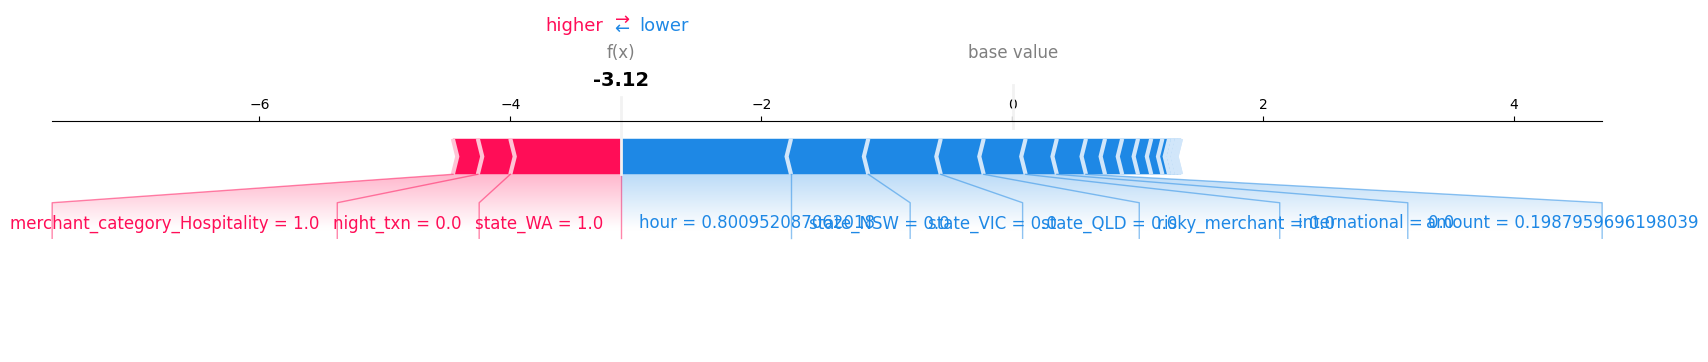

In [34]:
fraud_pos = (y_test_reset == 1).idxmax()
shap.force_plot(
    explainer_xgb.expected_value,
    shap_values_xgb[fraud_pos],
    X_test_reset.iloc[fraud_pos],
    matplotlib=True
)


In [39]:
import joblib

# Save XGBoost model
joblib.dump(model, 'xgb_fraud_model.joblib')
print("XGBoost model saved as xgb_fraud_model.joblib")


XGBoost model saved as xgb_fraud_model.joblib


In [40]:
# Save TabNet model
tabnet.save_model('tabnet_fraud_model')
print("TabNet model saved as tabnet_fraud_model.zip")


Successfully saved model at tabnet_fraud_model.zip
TabNet model saved as tabnet_fraud_model.zip


In [41]:
from google.colab import files

# Download XGBoost model
files.download('xgb_fraud_model.joblib')

# Download TabNet model (zipped)
files.download('tabnet_fraud_model.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>